# Построение ML-продукта для предсказания повторной покупки покупателя
**Описание проекта**
<br>Предоставлено три файла - каждый файл это отдельный интернет-магазин:
- `marketplace` – мультикатегорийный магазин с посещаемостью более 8-ми млн сессий в месяц, 
- `apparel` – магазин одежды, по характеристикам похожий на маркетплейс, 
- `gifts` - очень маленький магазин подарков.

<br>В данных - обезличенная история покупок клиентов за определенный период.

**Цель проекта**
- Необходимо создать решение для предсказания совершения покупателем повторной покупки в течение ближайших 30-ти дней 

**Задачи**
- Необходимо выбрать и обосновать метрику (Заказчику важен положительный класс покупателей),
- предложить решение, способное с высокой вероятностью предсказывать поведение клиентов.

**Ход исследования**
- загрузка данных и ознакомление с ними,
- EDA,
- создание новых признаков (при необходимости),
- отбор финального набора обучающих признаков,
- подготовка данных для обучения,
- выбор и обучение моделей (разных архитектур),
- оценка качества предсказания лучшей модели на тестовой выборке,
- анализ важности признаков лучшей модели,
- отчёт по проведённому исследованию.

**Описание данных**
<br>`client_id` - идентификатор клиента,
<br>`quantity` - количество товара в заказе,
<br>`price` - цена единицы товара в заказе,
<br>`message_id` - идентификатор сообщения из рассылки,
<br>`date` - дата покупки

**Выбор метрик**
- данная задача является задачей классификации,
  <br>ориентированная на временные ряды,
- метрики для оптимизации будут выбраны после ознакомления с данными,
- предварительно - `ROC-AUC`

## Настройка рабочей среды

In [ ]:
# !pip list
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install xlrd

In [1]:
import random
import numpy as np
import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

/tmp/ipykernel_64385/2139654346.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Установка констант

In [2]:
RANDOM_STATE = 42

Установка random_state

In [3]:
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

## Загрузка и первичная обработка данных

In [4]:
try:
    marketplace = pd.read_csv('data/marketplace-purchases.csv', parse_dates=['date', 'created_at'])
    apparel = pd.read_csv('data/apparel-purchases.csv', parse_dates=['date'])
    gifts = pd.read_csv('data/gifts-purchases.csv', parse_dates=['date'])
    h22 = pd.read_csv('data/holidays_calendar_2022.csv')
    h23 = pd.read_csv('data/holidays_calendar_2023.csv')
    print('загружено из каталога "data"')
except:
    marketplace = pd.read_csv(userdata.get('marketplace_path'), parse_dates=['date', 'created_at'])
    apparel = pd.read_csv(userdata.get('apparel_path'), parse_dates=['date'])
    gifts = pd.read_csv(userdata.get('gifts_path'), parse_dates=['date'])
    h22 = pd.read_csv(userdata.get('h22_path'))
    h23 = pd.read_csv(userdata.get('h23_path'))
    print('загружено из каталога Google Drive')

загружено из каталога "data"


### Функция для проведения исследования
Ввиду того, что все предоставленные таблицы однотипны, для их исследования можно написать функцию

In [5]:
from research_class import DatasetExplorer

### Holidays

In [6]:
def date_preparation(data, year):
    '''
    - на вход принимает датасет с праздниками и год этого датасета
    - возвращает обработанный датасет
    '''
    data = data.reset_index(drop=True).T[:13]
    data = data.set_axis(data.iloc[0], axis=1)[1:]
    data.insert(0, 'month', range(1, len(data) + 1))
    data.insert(0, 'year', year)
    data = data.replace(['\+', '\*'], '', regex=True)
    data[year] = data[year].str.split(',')
    data = data.explode(year)
    data = data.rename(columns={year: 'day'})
    data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
    
    return data

In [7]:
h22 = date_preparation(h22, 2022)
h23 = date_preparation(h23, 2023)
holidays = pd.concat([h22, h23], ignore_index=True)
holidays.sample(5)

Год/Месяц,year,month,day,date
24,2022,2,27,2022-02-27
6,2022,1,7,2022-01-07
152,2023,3,18,2023-03-18
209,2023,9,17,2023-09-17
237,2023,12,17,2023-12-17


#### Выводы и наблюдения
- подготовлен датасет, в котором перечислены все выходные и праздничные дни в РФ в 2022 и 2023 годах

### Marketplace

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   client_id   48182 non-null  int64         
 1   quantity    48182 non-null  int64         
 2   price       48182 non-null  float64       
 3   message_id  48182 non-null  object        
 4   created_at  48182 non-null  datetime64[ns]
 5   date        48182 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(1)
memory usage: 2.2+ MB


,client_id,quantity,price,message_id,created_at,date
38957,1515915625520049365,1,58798.0,1515915625520049365-1561-63f5b21423c41,2023-02-22,2023-02-22 07:54:26
17593,1515915625533002613,1,6299.0,1515915625517580463-1596-640181a7da72a,2023-03-03,2023-03-03 06:52:27
29253,1515915625559756457,1,130998.0,1515915625519524273-2034-64d9fe880cc04,2023-08-14,2023-08-14 13:52:07
1219,1515915625470243155,1,4108.0,1515915625470243155-2100-6501b27795027,2023-09-14,2023-09-14 10:14:26
6432,1515915625497262383,1,7198.0,1515915625497262383-1244-6367468693386,2022-11-07,2022-11-07 09:58:39


количество полных дубликатов строк: 2159


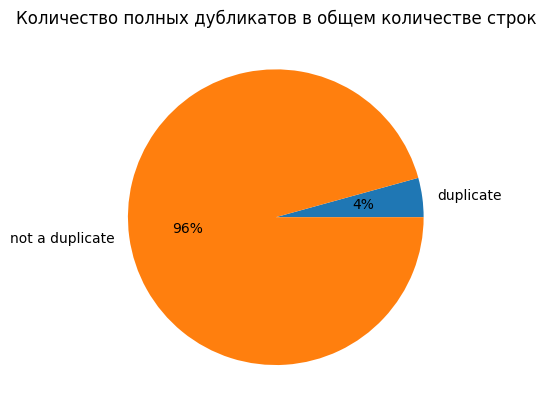

количество уникальных значений client_id:
		17787
количество уникальных значений client_id в общем количестве client_id:
		38.648%


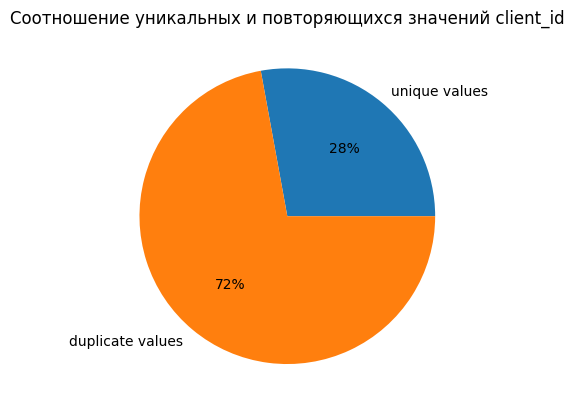

количество уникальных значений message_id:
		20940
количество уникальных значений client_id в общем количестве client_id:
		45.499%


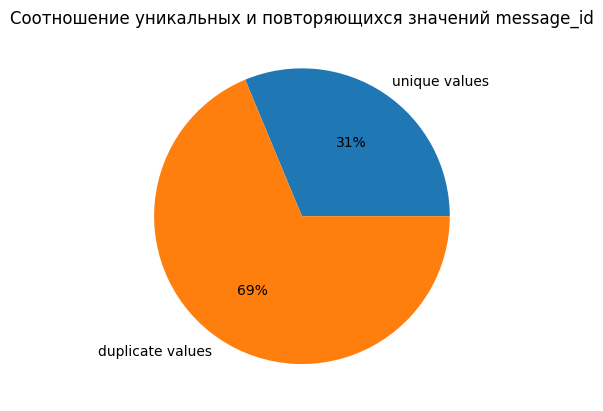

описание quantity:
		count    46023.000000
mean         1.017904
std          0.552672
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         50.000000
Name: quantity, dtype: float64
количество уникальных значений quantity: 15


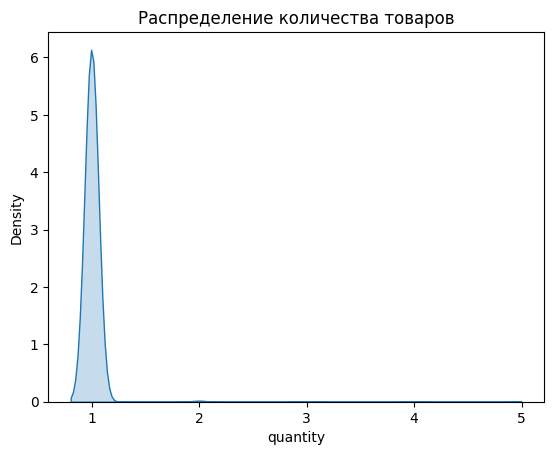

описание price:
		count    4.602300e+04
mean     2.871027e+04
std      4.548493e+04
min      0.000000e+00
25%      1.558000e+03
50%      1.099800e+04
75%      3.799800e+04
max      1.299998e+06
Name: price, dtype: float64
количество уникальных значений price: 4991


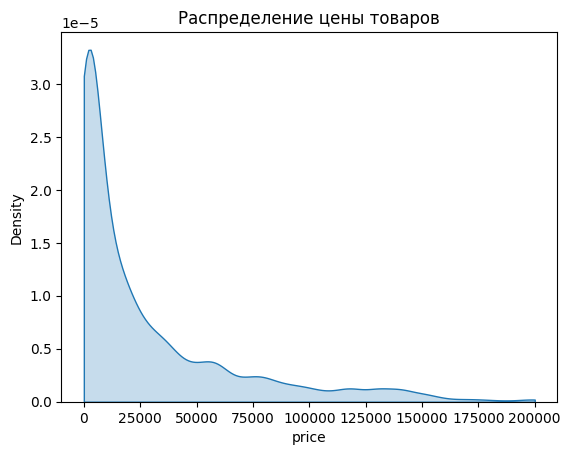

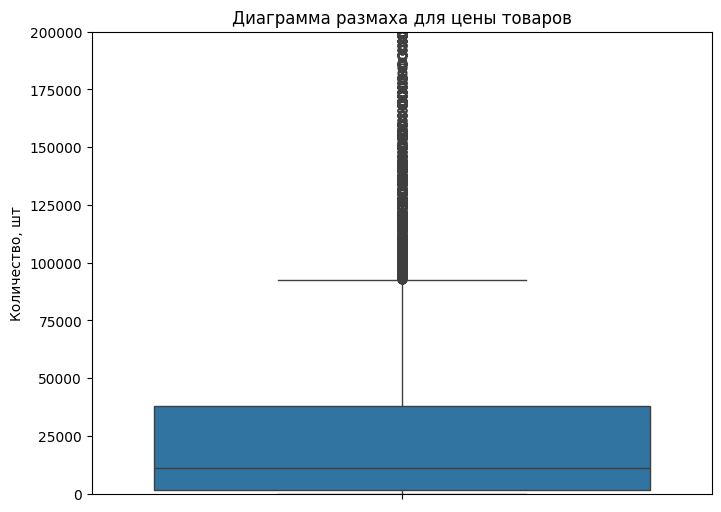

Первая запись в датафрейме: 2022-10-26 08:35:46
		Последняя запись в датафрейме: 2023-10-26 13:34:11
Информация о датасете после первичных преобразований:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46023 entries, 0 to 46022
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   client_id   46023 non-null  int64         
 1   quantity    46023 non-null  int64         
 2   price       46023 non-null  float64       
 3   message_id  46023 non-null  object        
 4   created_at  46023 non-null  datetime64[ns]
 5   date        46023 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(1)
memory usage: 2.1+ MB


In [8]:
explorer_marketplace = DatasetExplorer(marketplace)
explorer_marketplace.explore_dataset()  # 48182

In [9]:
print(f"""Количество совпадений в признаках created_at и date по отношению ко всему датафрейму:
{(marketplace['created_at'] == marketplace['date'].dt.date).sum() / marketplace.shape[0] * 100:.0f}%""")

Количество совпадений в признаках created_at и date по отношению ко всему датафрейму:
100%


Удаление признака created_at

In [10]:
marketplace = marketplace.drop(['created_at'], axis=1)

#### Выводы и наблюдения
- пропусков в данных не обнаружено;
- удалены полные дубликаты строк (менее 5% от датафрейма);
- количество уникальных значений `client_id` составляет чуть больше трети от всех,
  <br>что свидетельствует о повторных действиях клиентов;
-  медиана и среднее в `quantity` практически равны, что говорит о нормальности распределения;
-  в признаке `price` среднее значение больше медианного, наблюдается правосторонняя асимметрия,
  <br>распределение отличается от нормального;
- в признаке `price`обнаружено большое количество выбросов, удалять их нет необходимости,
  <br>т.к. они помогут в дальнейшем исследовании;
- период записей в датафрейме - 1 год (с 26.10.22 по 26.10.23);
-  признаки `created_at` и `date` полностью совпадают, принимаю решение удалить `created_at`.

### Apparel

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133104 entries, 0 to 133103
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   client_id       133104 non-null  int64         
 1   quantity        133104 non-null  int64         
 2   price           133104 non-null  float64       
 3   date            133104 non-null  datetime64[ns]
 4   message_id      133104 non-null  object        
 5   recommended_by  133104 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 6.1+ MB


,client_id,quantity,price,date,message_id,recommended_by
102111,1515915625966130065,1,210.0,2023-08-04,1515915625966130065-13598-64cd08bcf10da,bulk_message
115476,1515915625764066035,1,346.0,2022-12-23,1515915625764066035-5286-62c52c0348b65,bulk_message
100772,1515915625764187190,1,2499.0,2023-06-29,1515915625764187190-13406-649aaef97a8c2,bulk_message
122255,1515915625817356226,1,2563.0,2022-11-26,1515915625817356226-8169-6381ebc51689f,bulk_message
82710,1515915625559323786,1,199.0,2023-06-28,1515915625776574312-13406-649aafca60b77,bulk_message


количество полных дубликатов строк: 59250


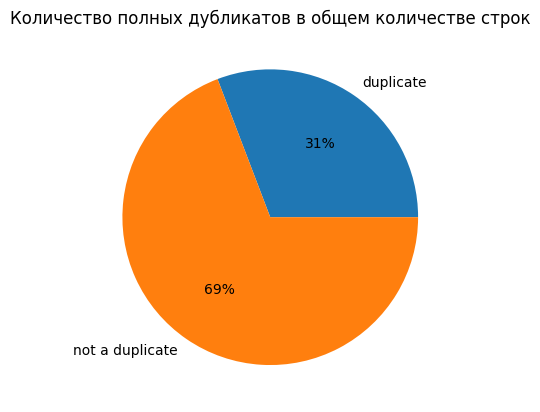

количество уникальных значений client_id:
		28891
количество уникальных значений client_id в общем количестве client_id:
		39.119%


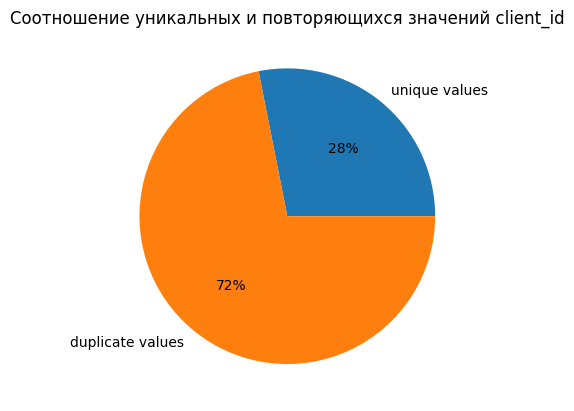

количество уникальных значений message_id:
		25426
количество уникальных значений client_id в общем количестве client_id:
		34.427%


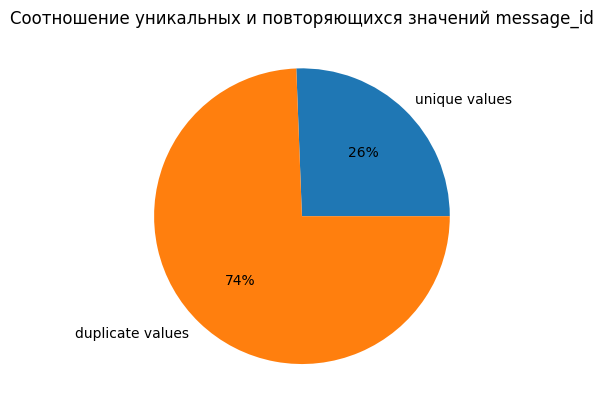

описание quantity:
		count    73854.000000
mean         1.007163
std          0.196003
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         30.000000
Name: quantity, dtype: float64
количество уникальных значений quantity: 12


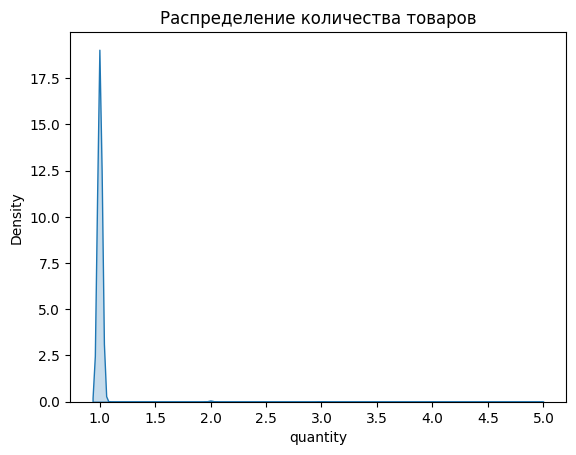

описание price:
		count    73854.000000
mean      1193.189509
std       1344.678951
min          1.000000
25%        361.000000
50%        939.000000
75%       1621.000000
max      63499.000000
Name: price, dtype: float64
количество уникальных значений price: 3335


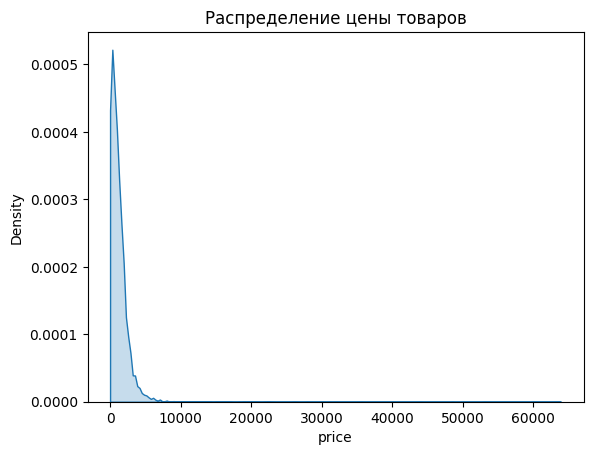

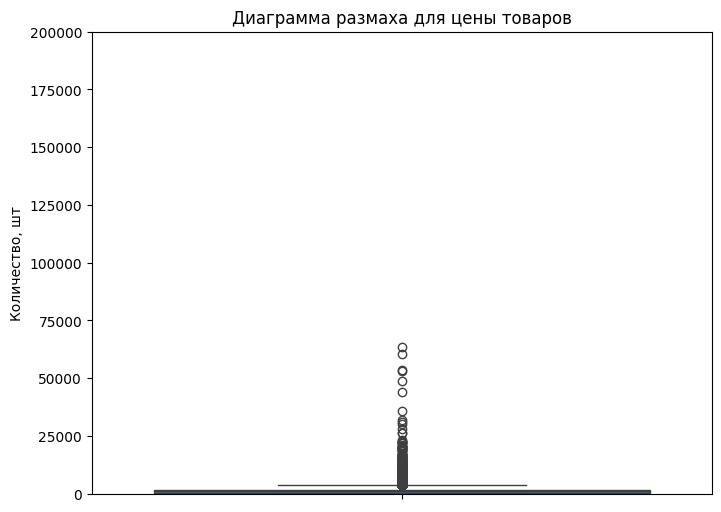

Первая запись в датафрейме: 2022-10-26 00:00:00
		Последняя запись в датафрейме: 2023-10-26 00:00:00
Информация о датасете после первичных преобразований:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73854 entries, 0 to 73853
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   client_id       73854 non-null  int64         
 1   quantity        73854 non-null  int64         
 2   price           73854 non-null  float64       
 3   date            73854 non-null  datetime64[ns]
 4   message_id      73854 non-null  object        
 5   recommended_by  73854 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 3.4+ MB


In [12]:
explorer_apparel = DatasetExplorer(apparel)
explorer_apparel.explore_dataset()  # 133104

In [13]:
print(f"""уникальные значения recommended_by:
{apparel['recommended_by'].value_counts().sort_index(ascending=False)}""")

уникальные значения recommended_by:
recommended_by
bulk_message    73854
Name: count, dtype: int64


Удаление признака recommended_by

In [14]:
apparel = apparel.drop(['recommended_by'], axis=1)

#### Выводы и наблюдения
- пропусков в данных не обнаружено;
- удалены полные дубликаты строк (более 30% от датафрейма);
- количество уникальных значений `client_id` составляет около трети от всех,
  <br>что свидетельствует о повторных действиях клиентов;
- медиана и среднее в `quantity` практически равны, что говорит о нормальности распределения;
- в признаке `price` среднее значение больше медианного, наблюдается правосторонняя асимметрия,
  <br>распределение отличается от нормального;
- в признаке `price` обнаружено большое количество выбросов, удалять их нет необходимости,
  <br>т.к. они помогут в дальнейшем исследовании;
- период записей в датафрейме - 1 год (с 26.10.22 по 26.10.23);
- в признаке `recommended_by` только одно значение, принимаю решение удалить данный признак.

### Gifts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   client_id       755 non-null    int64         
 1   quantity        755 non-null    int64         
 2   price           755 non-null    float64       
 3   date            755 non-null    datetime64[ns]
 4   message_id      755 non-null    object        
 5   recommended_by  755 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 35.5+ KB


,client_id,quantity,price,date,message_id,recommended_by
374,1515915625819603986,1,4375.0,2022-12-07,1515915625819603986-8443-638f449ca1be8,bulk_message
417,1515915625853062360,1,18420.0,2023-01-12,1515915625853062360-9331-63c0128a7a5f2,bulk_message
476,1515915625855635892,1,2792.0,2023-04-05,1515915625855635892-11511-642ad5e3a311b,bulk_message
110,1515915625856252097,1,81490.0,2023-07-01,1515915625856252097-13815-649ede4e37fe6,bulk_message
326,1515915625835004145,1,2790.0,2023-05-23,1515915625835004145-12742-646b14f25ecdf,bulk_message


количество полных дубликатов строк: 0


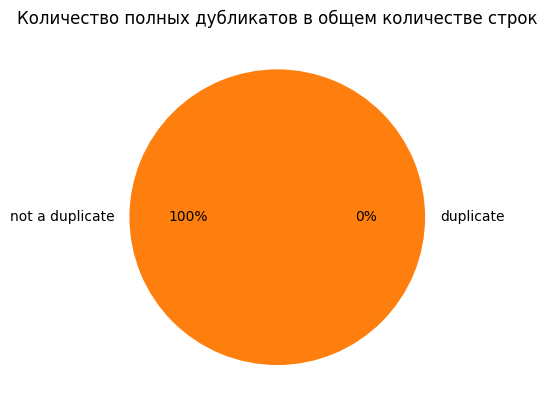

количество уникальных значений client_id:
		326
количество уникальных значений client_id в общем количестве client_id:
		43.179%


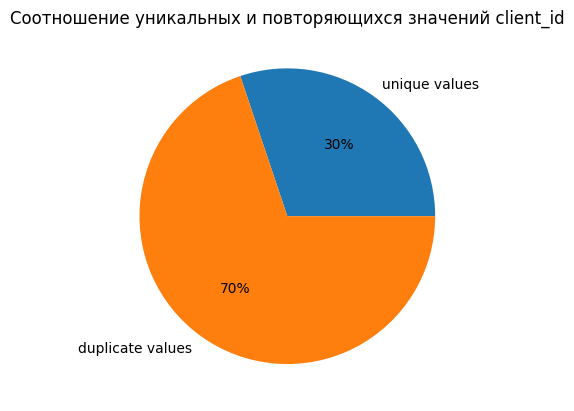

количество уникальных значений message_id:
		342
количество уникальных значений client_id в общем количестве client_id:
		45.298%


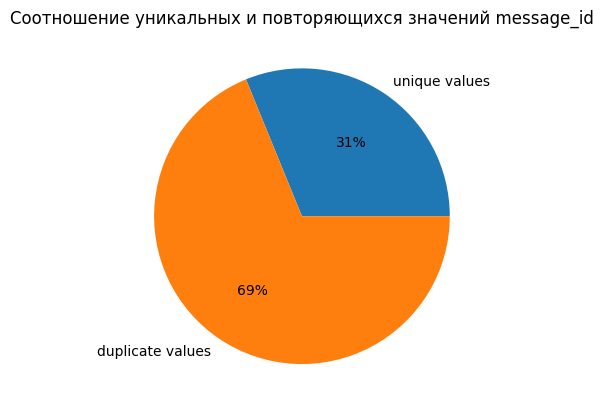

описание quantity:
		count    755.000000
mean       1.003974
std        0.062952
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: quantity, dtype: float64
количество уникальных значений quantity: 2


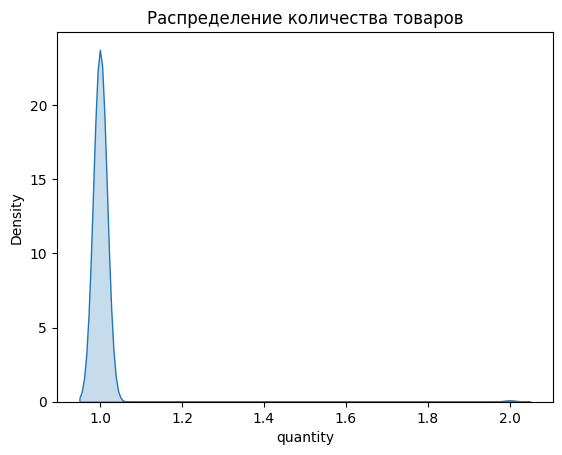

описание price:
		count       755.000000
mean      14767.966887
std       18123.505388
min         656.000000
25%        3963.500000
50%        7671.000000
75%       18610.000000
max      173586.000000
Name: price, dtype: float64
количество уникальных значений price: 598


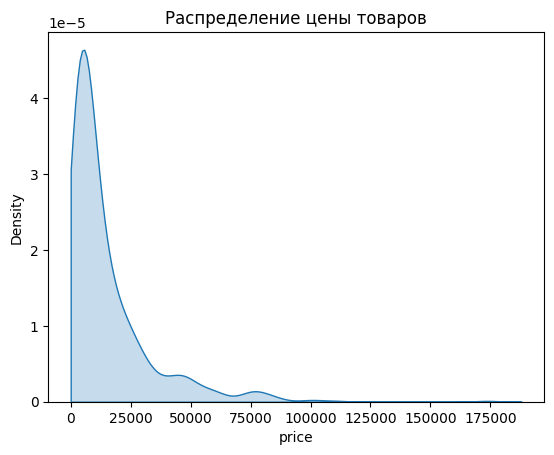

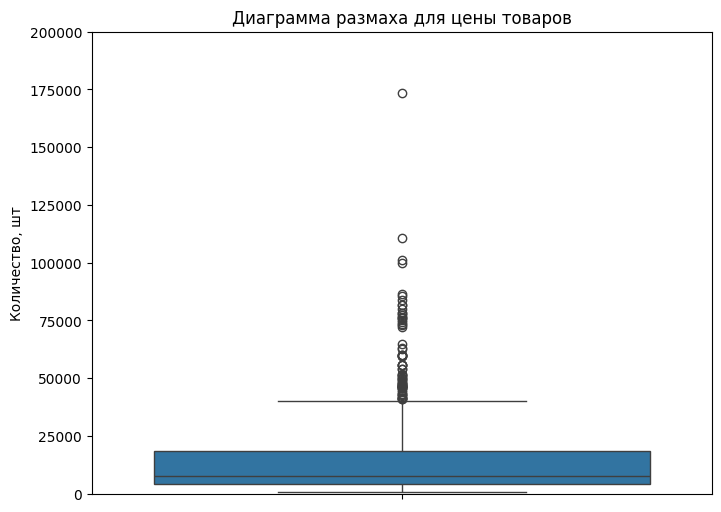

Первая запись в датафрейме: 2022-10-26 00:00:00
		Последняя запись в датафрейме: 2023-10-24 00:00:00
Информация о датасете после первичных преобразований:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   client_id       755 non-null    int64         
 1   quantity        755 non-null    int64         
 2   price           755 non-null    float64       
 3   date            755 non-null    datetime64[ns]
 4   message_id      755 non-null    object        
 5   recommended_by  755 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 35.5+ KB


In [17]:
explorer_gifts = DatasetExplorer(gifts)
explorer_gifts.explore_dataset()  # 811

#### Выводы и наблюдения
- 

### Дополнение функции

In [ ]:

# Создаем исходный DataFrame
data = {
    'client_id': [1, 2, 3, 1, 2, 4, 5, 1],
    'date': ['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-10', '2022-01-15', '2022-02-01', '2022-02-02', '2022-03-10']
}
df = pd.DataFrame(data)

# Преобразуем столбец 'date' в тип datetime
df['date'] = pd.to_datetime(df['date'])

# Создаем новый столбец 'признак' и устанавливаем значение 1 для повторяющихся значений 'client_id' в течение 30 дней
df['repeat_purchase_within_30d'] = df.duplicated(subset='client_id', keep=False) & (df['date'].diff().dt.days <= 30)
df['repeat_purchase_within_30d'] = df['repeat_purchase_within_30d'].astype(int)

# Выводим результат
print(df)


Добавление информации о днях недели

Изучение сезонности

Проверка корреляций

In [11]:
marketplace.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46023 entries, 0 to 46022
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   client_id   46023 non-null  int64         
 1   quantity    46023 non-null  int64         
 2   price       46023 non-null  float64       
 3   message_id  46023 non-null  object        
 4   date        46023 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 1.8+ MB
